In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate

In [35]:
#formatting plots a little nicer
plt.style.use('default')
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['figure.dpi'] = 400
mpl.rcParams['pdf.fonttype'] = 42 # use to make sure exported pdf's have editable text

In [37]:
import matplotlib.animation as manimation

#ax = plt.axes()
plt.rcParams["figure.figsize"] = (7,6) # (w, h)
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, bitrate=4000)
dpi_movie=300

In [39]:
k = 2
rho = 2650
kappa = 1e-6
c = k/(rho*kappa)
alpha = 0.3
sigma = 5.67e-8

d0 = 4 # distance to tree in meters
r = 0.5 #radius of tree in m
h = 5 # total height of tree

tfire = 87.23969403904118 # seconds
Tfire = 1500 # in celsius
TKfire = Tfire + 273.15 # in Kelvin

In [41]:
xmax = 0.2
dx = 0.01

tmax = 7200
dt = 25

In [43]:
x = np.arange(0, xmax+dx, dx)
xmid = np.arange(dx/2, xmax+(dx/2), dx)

t = np.arange(0,tmax+dt,dt)
nplots = 200
tplot = tmax / nplots

index_1cm=np.where(xmid==0.011)[0]
index_2cm=np.where(xmid==0.021)[0]

In [45]:
T0 = 10 + 273.15
T = T0 * np.ones(np.size(xmid))

In [47]:
tvals = [x for x in range(210)]
def Temp(time):
    temp = -time*(time-3600)/3e3
    temp[temp<10]=10
    return temp

(0.0, 1353.15)

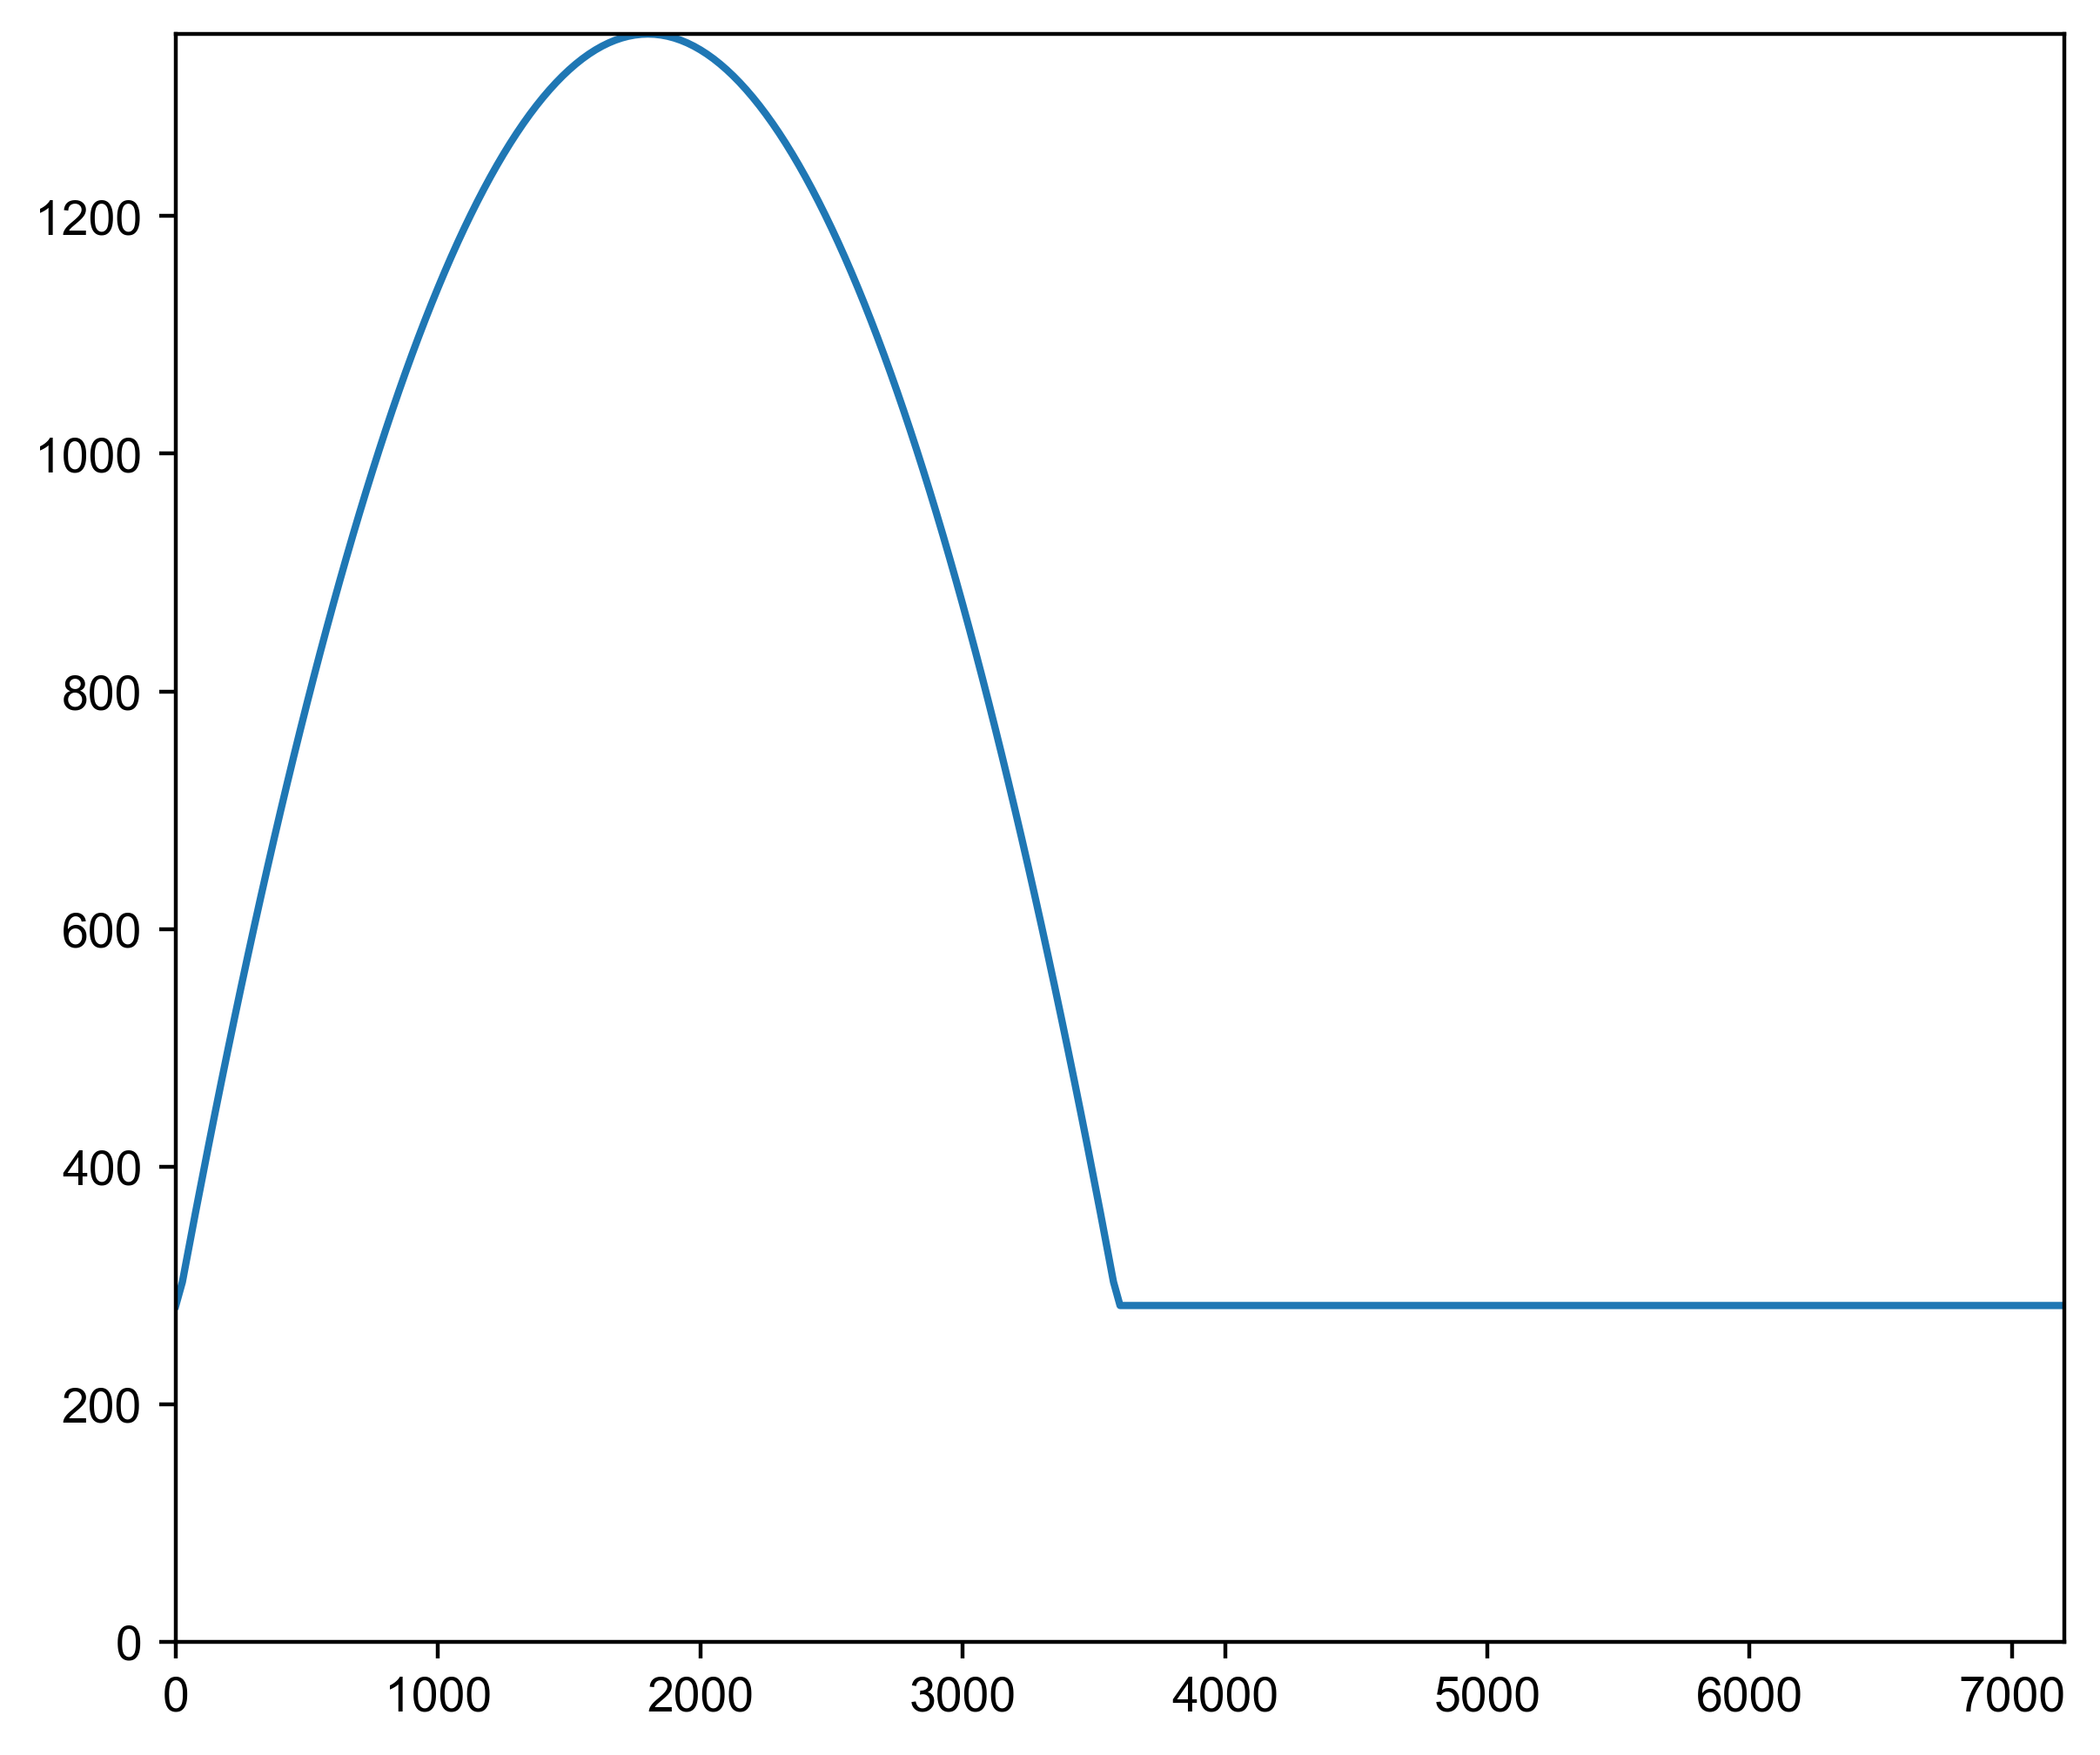

In [49]:
Tf = Temp(t)+273.15
plt.plot(t,Tf)
plt.xlim(0,tmax)
plt.ylim(0,max(Tf))

In [51]:
def Q_in(z,time,d): #z is height on wall
    return (1-alpha)*2*r*sigma*Tf[time]**4 / (2*d*np.pi) * ((h*d*(d**2+z*(h-z)))/((d**2+z**2)*(d**2+(z-h)**2)) + np.arctan(z/d) - np.arctan((z-h)/d))

(0.0, 15.0)

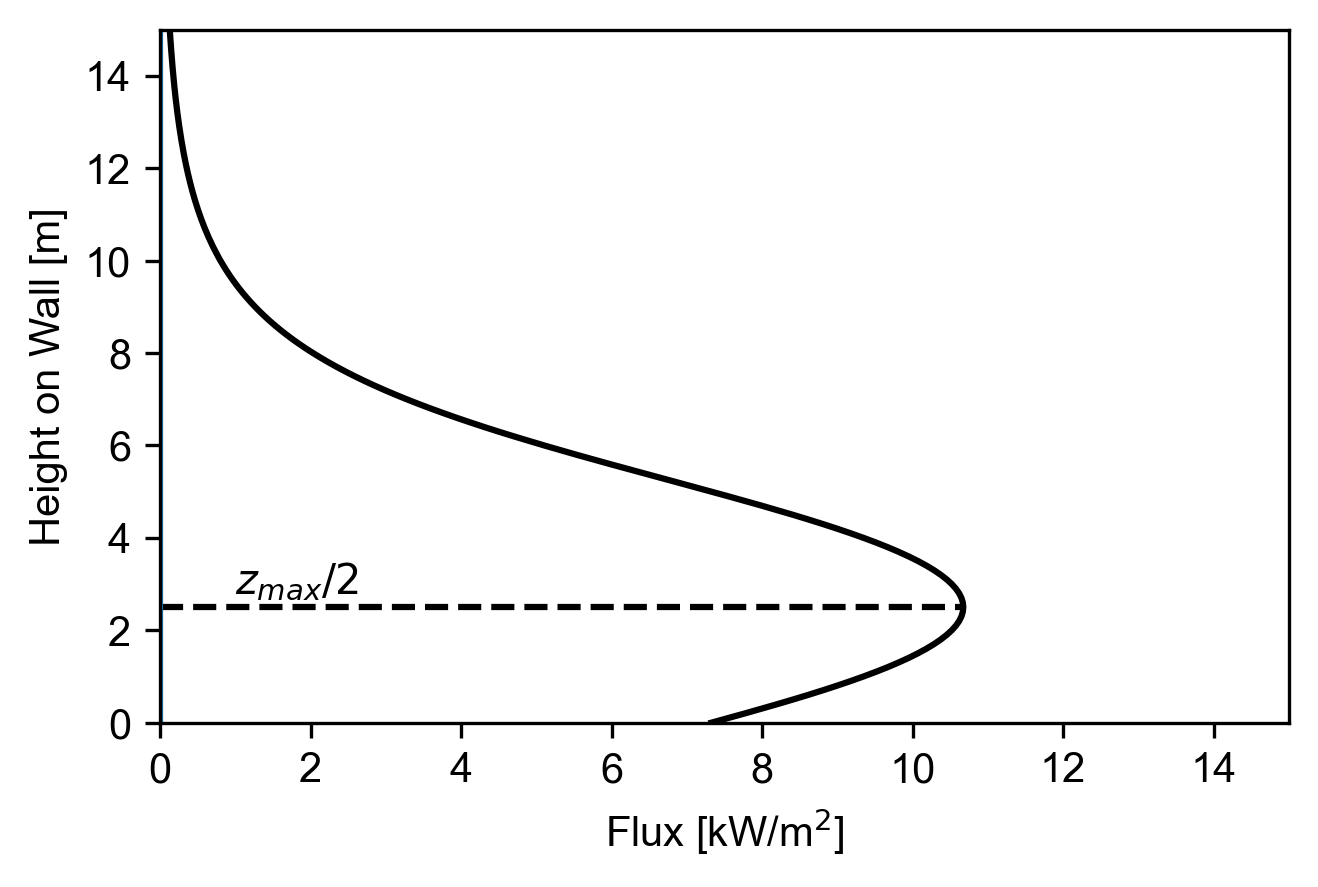

In [53]:
fig, ax1 = plt.subplots(figsize=(1.618*3,3), dpi=300)

z_vals = np.arange(0,15,0.1)
Q = Q_in(z_vals,len(t)//4,4)
plt.plot(Q/1000,z_vals, c='k')
plt.plot([0,max(Q)/1000],[h/2,h/2], c='k', ls='--')
plt.plot([0,0],[0,20])
plt.xlabel('Flux [kW/m$^2$]')
plt.ylabel('Height on Wall [m]')
plt.text(1,2.8,r'$z_{max}/2$')
plt.ylim(0,15)
plt.xlim(0,15)

In [55]:
%%time

Q = np.zeros(np.size(x))
T0 = 10 + 273.15

Tmin = 10 + 273.15
R=8.314
Ea=35000
spall_length = 0.01

dz = 0.05
z0 = 0
zmax = 15
z_vals = np.arange(z0,zmax+dz,dz)

T = T0*np.ones((len(t),len(xmid),len(z_vals)))

nfires = 3000
d = d0*np.ones((nfires+1,len(z_vals)))
damage = np.zeros((nfires+1,len(t),len(xmid),len(z_vals)))

for n in range(nfires):
    T = T0*np.ones((len(t),len(xmid),len(z_vals)))
    Q = np.zeros(np.size(x))
    for z in range(len(z_vals)): # array this loop    
        for i in range(len(t)-1):
            Qin = Q_in(z_vals[z],i,d[n,z])
            Qout = sigma * T[i,0,z]**4
            Qbase = 0
            Q0 = Qin - Qout
            Q[0] = Q0
            Q[-1] = Qbase
            Q[1:-1] = -k*np.diff(T[i,:,z])/dx
            dTdt = -(1/(rho*c))*np.diff(Q)/dx
        
            T[i+1,:,z] = T[i,:,z] + dTdt*dt
            
            damage_add = (np.exp(-Ea/(R*T[i,:,z]))-np.exp(-Ea/(R*Tmin)))*dt
            damage_add[damage_add<0]=0
            damage[n,i+1,:,z] = damage[n,i,:,z] + damage_add

        if damage[n,-1,0,z]>=1:
            d[n+1,z]=d[n,z]+spall_length
            damage[n+1,0,:-2,z]=damage[n,-1,2:,z]

        else:
            d[n+1,z]=d[n,z]
            damage[n+1,0,:,z]=damage[n,-1,:,z]

CPU times: user 56min 52s, sys: 11.8 s, total: 57min 4s
Wall time: 57min 6s


In [24]:
n

1999

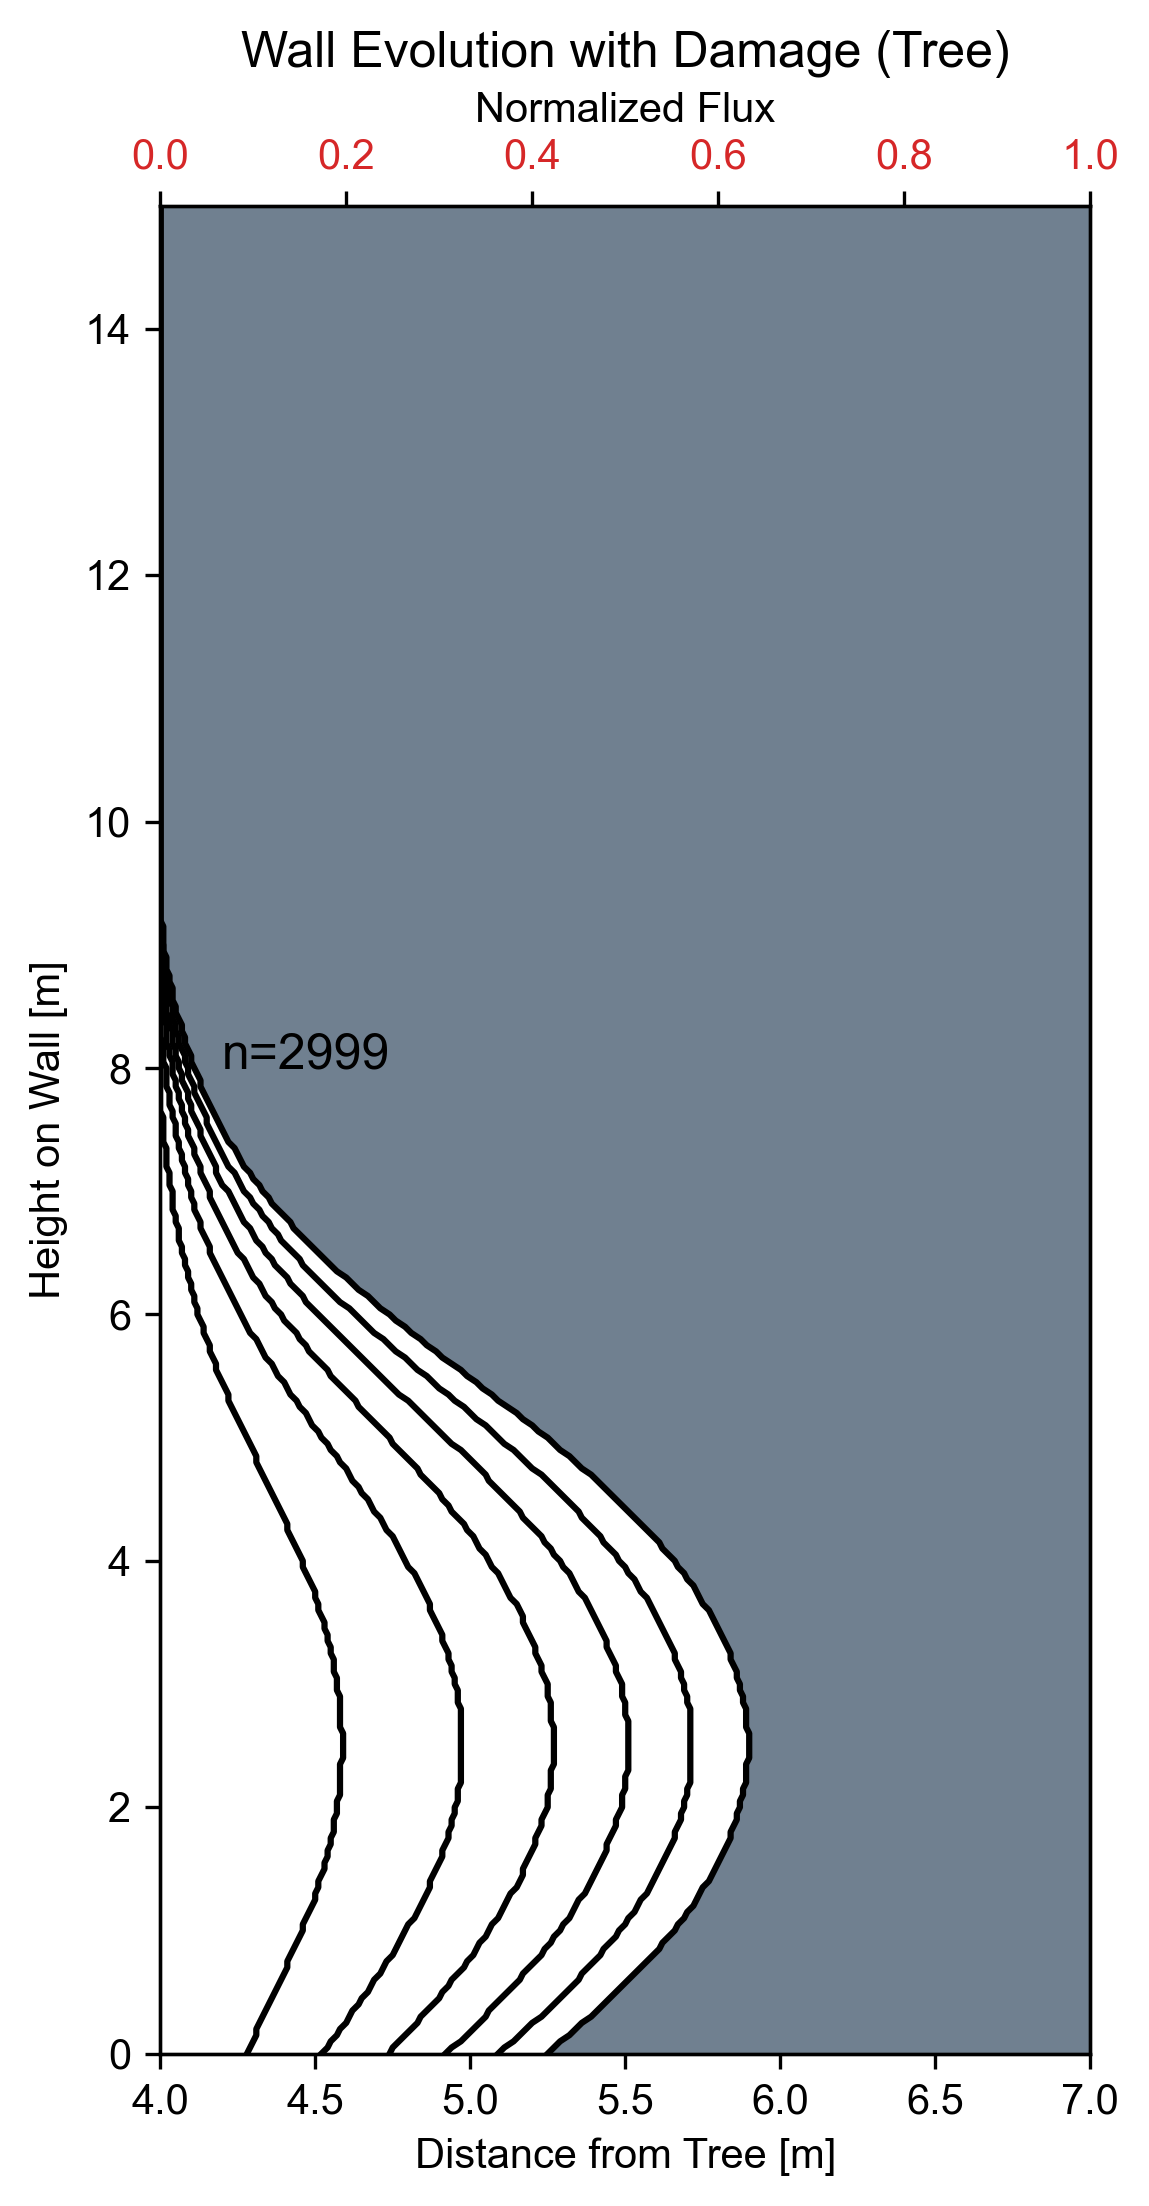

In [57]:
fig, ax1 = plt.subplots(1, 1, figsize=(4,8), dpi=300)
Q = np.array([Q_in(z_vals[z],50,d[n,z]) for z in range(len(z_vals))])
Q0 = np.array([Q_in(z_vals[z],50,d[0,z]) for z in range(len(z_vals))])
ax1.plot(d[n,:], z_vals, c='k')
ax1.fill_betweenx(z_vals,d[n,:], 7, color='slategrey')
ax1.text(4.2,8, 'n={}'.format(n), fontsize=12)
ax1.set_title('Wall Evolution with Damage (Tree)')
ax1.set_ylabel('Height on Wall [m]')
ax1.set_xlabel('Distance from Tree [m]')
ax1.set_xlim(4,7)
ax1.set_ylim(0,15)

ax2 = ax1.twiny()
color = 'tab:red'
#ax2.plot((Q/Qmax),z_vals, c='red')
#ax2.plot(Q0/Qmax,z_vals, c='red', ls='--')
ax2.tick_params(axis='x', labelcolor=color)
ax2.set_xlim(0,1)
ax2.set_xlabel('Normalized Flux')

if n>500:
    ax1.plot(d[500,:], z_vals, c='k')
if n>1000:
    ax1.plot(d[1000,:], z_vals, c='k')
if n>1500:
    ax1.plot(d[1500,:], z_vals, c='k')
if n>2000:
    ax1.plot(d[2000,:], z_vals, c='k')
if n>2500:
    ax1.plot(d[2500,:], z_vals, c='k')
if n>3000:
    ax1.plot(d[3000,:], z_vals, c='k')
if n>3500:
    ax1.plot(d[3500,:], z_vals, c='k')
if n>4000:
    ax1.plot(d[4000,:], z_vals, c='k')
if n>4500:
    ax1.plot(d[4500,:], z_vals, c='k')
#Q = np.array([Q_in(z_vals[z],50,d[n,z]) for z in range(len(z_vals))])
#ax1.plot((Q/np.max(Q))*3 + 4,z_vals, c='r')

In [75]:
np.max(d)

13.999999999999787

array([6.  , 6.  , 6.05, 6.1 , 6.1 , 6.15, 6.2 , 6.2 , 6.25, 6.25, 6.3 ,
       6.3 , 6.35, 6.36, 6.4 , 6.4 , 6.45, 6.45, 6.5 , 6.5 , 6.52, 6.55,
       6.55, 6.58, 6.6 , 6.6 , 6.63, 6.65, 6.65, 6.66, 6.69, 6.7 , 6.7 ,
       6.71, 6.74, 6.75, 6.75, 6.75, 6.75, 6.77, 6.78, 6.79, 6.8 , 6.8 ,
       6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 , 6.8 ,
       6.8 , 6.8 , 6.8 , 6.8 , 6.79, 6.78, 6.77, 6.75, 6.75, 6.75, 6.75,
       6.74, 6.71, 6.7 , 6.7 , 6.69, 6.66, 6.65, 6.65, 6.63, 6.6 , 6.6 ,
       6.58, 6.55, 6.55, 6.52, 6.5 , 6.5 , 6.45, 6.45, 6.4 , 6.4 , 6.36,
       6.35, 6.3 , 6.3 , 6.25, 6.25, 6.2 , 6.2 , 6.15, 6.1 , 6.1 , 6.05,
       6.  , 6.  , 5.95, 5.9 , 5.87, 5.85, 5.8 , 5.75, 5.7 , 5.7 , 5.65,
       5.6 , 5.55, 5.5 , 5.45, 5.4 , 5.4 , 5.35, 5.3 , 5.25, 5.2 , 5.15,
       5.1 , 5.05, 5.  , 5.  , 4.95, 4.9 , 4.85, 4.8 , 4.8 , 4.75, 4.7 ,
       4.65, 4.65, 4.6 , 4.55, 4.55, 4.5 , 4.5 , 4.45, 4.44, 4.4 , 4.4 ,
       4.35, 4.35, 4.3 , 4.3 , 4.3 , 4.25, 4.25, 4.

In [39]:
len(z_vals)

201

In [45]:
5000*6501*40*201/1e9

261.3402

In [59]:
#np.savetxt('tree_final_placements_alt4.txt', d)

In [61]:
#tree_place = np.loadtxt('tree_final_placements_alt4.txt')
#tree_place[-1]

array([5.25, 5.27, 5.29, 5.32, 5.34, 5.36, 5.39, 5.41, 5.43, 5.45, 5.47,
       5.49, 5.51, 5.53, 5.55, 5.57, 5.59, 5.61, 5.62, 5.64, 5.66, 5.67,
       5.69, 5.7 , 5.72, 5.73, 5.74, 5.75, 5.77, 5.78, 5.79, 5.8 , 5.81,
       5.82, 5.83, 5.84, 5.84, 5.85, 5.86, 5.86, 5.87, 5.87, 5.88, 5.88,
       5.89, 5.89, 5.89, 5.89, 5.9 , 5.9 , 5.9 , 5.9 , 5.9 , 5.89, 5.89,
       5.89, 5.89, 5.88, 5.88, 5.87, 5.87, 5.86, 5.86, 5.85, 5.84, 5.84,
       5.83, 5.82, 5.81, 5.8 , 5.79, 5.78, 5.77, 5.75, 5.74, 5.73, 5.72,
       5.7 , 5.69, 5.67, 5.66, 5.64, 5.62, 5.61, 5.59, 5.57, 5.55, 5.53,
       5.51, 5.49, 5.47, 5.45, 5.43, 5.41, 5.39, 5.36, 5.34, 5.32, 5.29,
       5.27, 5.25, 5.22, 5.2 , 5.17, 5.15, 5.12, 5.09, 5.07, 5.04, 5.02,
       4.99, 4.97, 4.94, 4.91, 4.89, 4.86, 4.84, 4.81, 4.79, 4.76, 4.74,
       4.71, 4.69, 4.67, 4.64, 4.62, 4.6 , 4.58, 4.55, 4.53, 4.51, 4.49,
       4.47, 4.45, 4.43, 4.42, 4.4 , 4.38, 4.36, 4.35, 4.33, 4.32, 4.3 ,
       4.29, 4.27, 4.26, 4.25, 4.24, 4.22, 4.21, 4.

In [41]:
arr = np.arange(0,15)
arr[arr%2==0]=0
arr

array([ 0,  1,  0,  3,  0,  5,  0,  7,  0,  9,  0, 11,  0, 13,  0])

In [ ]:
damage_add = (np.exp(-Ea/(R*np.max(T[:,:,z])))-np.exp(-Ea/(R*Tmin)))*dt
            damage_add[damage_add<0]=0
            damage[n,i+1,:,z] = damage[n,i,:,z] + damage_add